In [44]:
from mpi4py import MPI
import timeit
import numpy as np
import os
import meshio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

from manapy.ddm import readmesh
from manapy.ddm import Domain

from manapy.tools.pyccel_tools import initialisation_gaussian_2d, update_new_value, time_step
                          
from manapy.fvm.pyccel_fvm import (explicitscheme_convective_2d,
                                   explicitscheme_dissipative)

#from manapy.ast import Variable, LinearSystem

start = timeit.default_timer()

# mesh directory

dim = 2
readmesh('fin.msh', dim=dim, periodic=[0,0,0])

#Create the informations about cells, faces and nodes
domain = Domain(dim=dim)

faces = domain.faces
cells = domain.cells
halos = domain.halos
nodes = domain.nodes

nbnodes = domain.nbnodes
nbfaces = domain.nbfaces
nbcells = domain.nbcells


Starting ....
Number of Cells :  1152
Number of Nodes :  621


In [45]:

import numpy.linalg as LA

def circumcenter(C):
    ax = C[0][0]
    ay = C[0][1]
    bx = C[1][0]
    by = C[1][1]
    cx = C[2][0]
    cy = C[2][1]
    d = 2 * (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))
    ux = ((ax * ax + ay * ay) * (by - cy) + (bx * bx + by * by) * (cy - ay) + (cx * cx + cy * cy) * (ay - by)) / d
    uy = ((ax * ax + ay * ay) * (cx - bx) + (bx * bx + by * by) * (ax - cx) + (cx * cx + cy * cy) * (bx - ax)) / d
    return (ux, uy)


def norm2(exact, Sol, volume, nbelements, order):      
    Error = np.zeros(nbelements)
    Ex = np.zeros(nbelements)
    for i in range(nbelements):
        Error[i] = np.fabs(Sol[i]- exact[i]) * volume[i]
        Ex[i] = np.fabs(exact[i]) * volume[i]

    ErrorL2 = np.linalg.norm(Error,ord=order)/np.linalg.norm(Ex,ord=order)
    return ErrorL2

def cell_ver_coor():
    Cells_Cord=[]
    for s in cells._nodeid :
        Cell_Cord =[]
        for i in s :
            Cell_Cord.append(nodes._vertex[i][:-2])
        Cells_Cord.append(Cell_Cord)   
    return Cells_Cord

Cells_Cord = cell_ver_coor()

def save_paraview_one_variable(w, cells, nodes, dim, name):

    if dim == 2:
        elements = {"triangle": cells}
    elif dim == 3:
        elements = {"tetra": cells}

    points = []
    for i in nodes:
        points.append([i[0], i[1], i[2]])

    cells  = np.array(cells)
    points = np.array(points)

    data = {"w" : w}

    if len(w) == len(cells):
        data = {"w": data}

    if len(w) == len(cells):
        meshio.write_points_cells("visu"+name+".vtu",
                                    points, elements, cell_data=data, file_format="vtu")
    else:
        meshio.write_points_cells("visu"+str(w)+".vtu",
                                    points, elements, point_data=data, file_format="vtu")


def distance_point_segment(P, A, B):
   # Convertir les points en numpy arrays pour faciliter les calculs
   P = np.array(P)
   A = np.array(A)
   B = np.array(B)
   
   # Vecteur AB
   AB = B - A
   # Vecteur AP
   AP = P - A
   
   # Projection de AP sur AB
   t = np.dot(AP, AB) / np.dot(AB, AB)
   
   # Trouver le point de projection sur le segment
   if t < 0.0:
       point_projection = A
   elif t > 1.0:
       point_projection = B
   else:
       point_projection = A + t * AB
   
   # Calculer la distance entre P et le point de projection
   distance = np.linalg.norm(P - point_projection)
   
   return distance

def barycentre(C):
   ax, ay = C[0][0], C[0][1]
   bx, by = C[1][0], C[1][1]
   cx, cy = C[2][0], C[2][1]
   
   # Calcul du barycentre
   x = (ax + bx + cx) / 3.0
   y = (ay + by + cy) / 3.0
   
   return (x, y)

def dist_modified(x, y, z):
    x=np.asarray(x)
    y=np.asarray(y)
    z=np.asarray(z)
    return LA.norm(np.cross(y-x, x-z))/LA.norm(y-x) # Distance from z to a line drawn between x and y

In [46]:
E = cells.faceid[30]

In [47]:
for i in E:
    print(dist_modified(i,30))

4.644976193522331
2.217822942111948
2.217822942111948


In [48]:
# Calcul de l'Orthocentre
Barycentre = []
for i in range(nbcells):
    Barycentre.append(barycentre(Cells_Cord[i]))
#Barycentre

In [49]:
def Sol_initiale(x, y, alpha = 4):
    return np.exp(-1*(x**2+y**2)/0.25**2)

def Sol_exact(x,y,t, D=1, umax=1, sig = 0.25):
    val = (umax/(1+((4*D*t)/(sig**2)))*np.exp(-(x**2 + y**2)/(sig**2 + 4*D*t)))
    return val


In [50]:
def plot_isovaleurs(Barycentre, u):
   triang = Triangulation(Barycentre[:, 0], Barycentre[:, 1])
   plt.figure()
   plt.tricontourf(triang, u, levels=14)  # 14 niveaux de contour
   plt.colorbar()
   plt.title("isovaleurs")
   plt.xlabel('X')
   plt.ylabel('Y')
   plt.show()
Barycentre = np.array(Barycentre)

In [51]:
u_initiale = [ Sol_initiale(cell[0], cell[1]) for cell in domain.cells.center]
u_initiale = np.array(u_initiale)


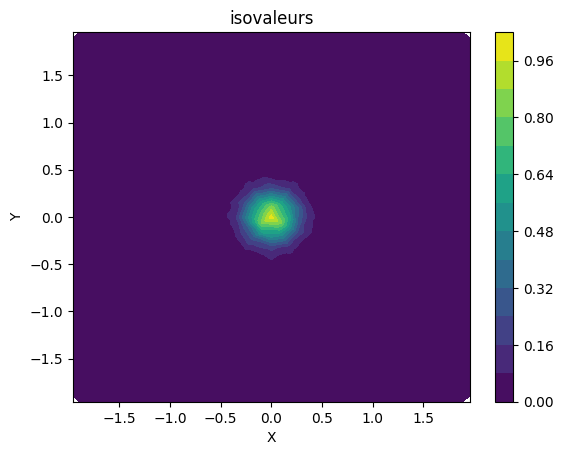

In [52]:
Barycentre = np.array(Barycentre)
plot_isovaleurs(Barycentre, u_initiale)

In [53]:
##---------------------Computing of dt-------------##
somme = []
for i in range(nbcells):
    k = cells.volume[i]
    list_faces = list(cells.faceid[i])
    elem = 0
    for j in range(3):
        mesure1 = faces.mesure[list_faces[j]]
        dist1 = dist_modified(list_faces[j],i)
        elem += mesure1/dist1
    somme += [1/k*elem]

lamda = 0.8
D = 1

dt = lamda/(D * max (somme))

print(dt)


save_n=0
temps=0
T=0.15
u=u_initiale
i=0
unew = np.zeros(nbcells)
while temps<=T:
    temps+=dt
    save_n+=1
    for j in range(nbcells):
        list_faces = cells.faceid[j]
        elem = 0
        for k in range(3):
            mesure_edge = faces.mesure[list_faces[k]]
            d1 = dist_modified(nodes._vertex[faces._nodeid[list_faces[k]][0]][:-2], nodes._vertex[faces._nodeid[list_faces[k]][1]][:-2] , Barycentre[faces.cellid[list_faces[k]][0]])
            d2 = dist_modified(nodes._vertex[faces._nodeid[list_faces[k]][0]][:-2], nodes._vertex[faces._nodeid[list_faces[k]][1]][:-2], Barycentre[faces.cellid[list_faces[k]][1]])
            dist1 = d1 + d2
            
            if j == faces.cellid[list_faces[k]][0]:
                u_diff = u[faces.cellid[list_faces[k]][1]] - u[faces.cellid[list_faces[k]][0]]
            else :
                u_diff = u[faces.cellid[list_faces[k]][0]] - u[faces.cellid[list_faces[k]][1]]
            elem += mesure1*u_diff/dist1
        unew[j] = u[j] - dt/(cells.volume[j]) * (-D)*elem

    u=np.copy(unew)
    i+=1
    #if i == 100 or i == 150 or i== 200:
      # save_paraview_one_variable(u, cells._nodeid, nodes._vertex, 2, "res_VF4"+str(save_n))
       
#save_paraview_one_variable(u, cells._nodeid, nodes._vertex, 2, "res_VF4"+str(save_n))
    


0.0013446613159937908


> 6-(a) Représentons les isovaleurs de la solution numérique obtenue sur chacun des trois maillages

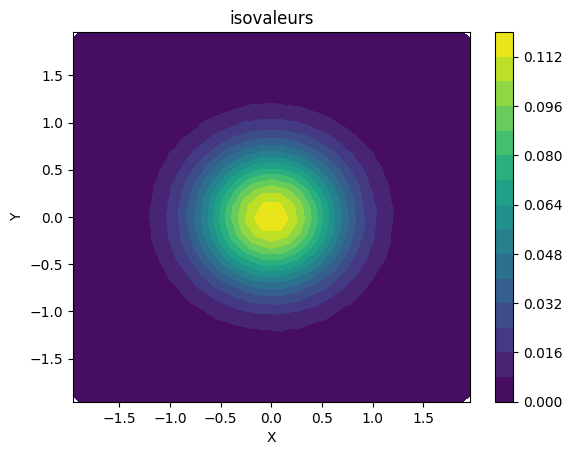

In [54]:
plot_isovaleurs(Barycentre, u)

> - ## (b)-Evaluation de l'erreur absolue en norme L1

In [55]:
u_exact = []
for i in Barycentre:
    u_exact.append(Sol_exact(i[0], i[1], T))
#u_exact  

In [56]:
np.sum(np.abs(u_exact-u))

2.2763786539266215

> - ## (c)-Représenter la solution exacte et les solutions numériques le long de l’axe y = 0 m

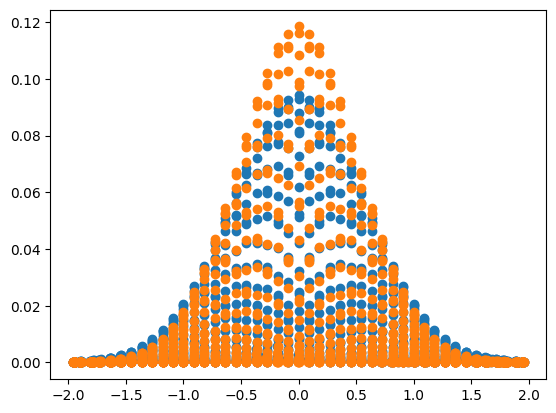

In [57]:
plt.figure()
plt.scatter(Barycentre[:,0], u_exact)
plt.scatter(Barycentre[:,0], u)